# Tutorial 2 - Evaluation of propagation velocity with NRV

The presence of the myelin sheath on large axonal fibers transforms the
so-called *continuous* conduction of unmyelinated fibers into a
*saltatory* conduction, largely increasing the speed of action potential
propagations. In this tutorial, we will simulated several myelinated and
unmyelinated fiber model using NRV and investigate how it effects the
action potential propagation speed.

First the ``nrv`` package is imported as well as the ``matplotlib``
package used for plotting nrv’s simulation outputs. We will also use
some ``numpy`` ’s function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")
import nrv

## Measuring Propagation Velocity of an unmyelinated fibers
First let’s create an ``unmyelinated`` object and specify the (y,z)
coordinates, diameter, length, and computationnal model used. The ``HH``
model (Hodgkin and Huxley, 1952) is used here for the example.

In [2]:
y = 0                               # axon y position, in [um]
z = 0                               # axon z position, in [um]
d = 1                               # axon diameter, in [um]
L = 2000                            # axon length, along x axis, in [um]
model = "HH"                        
axon = nrv.unmyelinated(y, z, d, L, model=model)

The unmyelinated fiber is stimulated with an intracellular current clamp
that is attach to the fiber using the ``insert_I_Clamp`` method. The
generated AP will be used to measure the propagation speed.

In [3]:
## Intracellular stimulation definition
t_start = 1                 # starting time, in [ms]
duration = 0.1              # duration, in [ms]
amplitude = 5               # amplitude, in [nA]
axon.insert_I_Clamp(0, t_start, duration, amplitude)

Axon is simulated and the simulated membrane’s voltage is rasterize to
facilitate the spike detection. For that, the ``rasterize`` method of the ``results`` object. The function detects the
presence of AP in the fiber across time and space using a threshold function.

In [4]:
t_sim = 10                  # simulation time, in [ms] 
results = axon(t_sim=t_sim)
results.rasterize("V_mem")

We can plot the rasterized result to verify that an AP is indeed
propagating through the fiber.

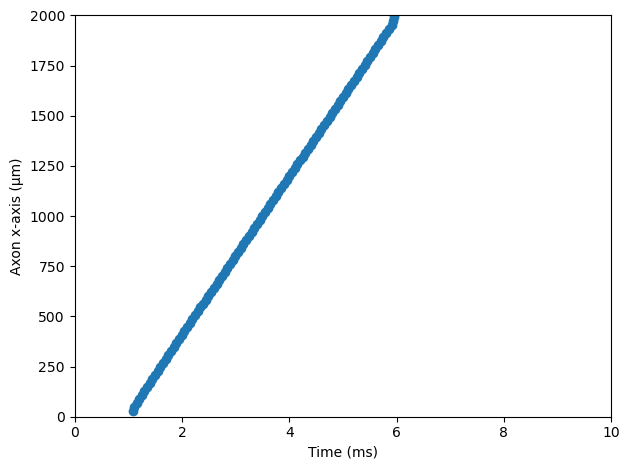

In [5]:
results.rasterize("V_mem")
fig, ax = plt.subplots(1)
results.raster_plot(ax,'V_mem')
ax.set_ylabel("Axon x-axis (µm)")
ax.set_xlabel("Time (ms)")
ax.set_xlim(0,results.tstop)
ax.set_ylim(0,np.max(results.x_rec))
fig.tight_layout()

The velocity of the propagating AP can be simply evaluated with the
built-in method ``get_avg_AP_speed`` of the ``results`` dictionary.

In [6]:
unmyelinated_speed = results.get_avg_AP_speed()
unmyelinated_speed          #in m/s

0.405

## Measuring Propagation Velocity of a myelinated fibers

Those steps can be repeated but with a myelinated fiber model. Note that
we defined a fixed number of nodes-of-ranvier and derived the length of
the fiber from this number, rather than specifying its length directly.

In [7]:
## Axon creation
y = 0                                 # axon y position, in [um]
z = 0                                 # axon z position, in [um]
d = 10                                # axon diameter, in [um]
L = nrv.get_length_from_nodes(d, 21)  #Axon length is 21 node of Ranvier
model = "MRG"
axon = nrv.myelinated(y, z, d, L, model=model)

## test pulse
t_start = 1
duration = 0.1
amplitude = 5
axon.insert_I_Clamp(0, t_start, duration, amplitude)
t_sim = 5

## Simulation
results = axon(t_sim=t_sim)

results.rasterize("V_mem")
myelinated_speed = results.get_avg_AP_speed()
myelinated_speed

65.094

As expected, the AP propagation is much faster in a large myelinated
axon than small unmyelinated one!

## Velocity-diameter relationship

The velocity of AP propagation in a fiber increases with its diameter.
Let’s verify this with NRV and plot the propagation velocity diameter
relationship for unmyelinated fibers. This typically takes less than 30s to calculate.

Text(0, 0.5, 'speed ($m.s^{-1}$)')

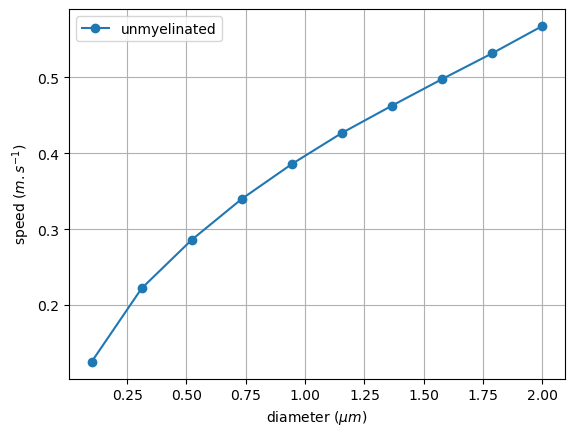

In [8]:
unmyelinated_diameters = np.linspace(0.1, 2, 10)            #10 unmyelinated fibers with diameter ranging from 0.1µm to 2µm.
unmyelinated_speed = []                                     #Empty list to store results

## Axon fixed parameters
y = 0
z = 0
L = 5000
model = "HH" 

## test pulse fixed parameters
t_start = 1
duration = 0.1
amplitude = 5

t_sim = 10
for d in unmyelinated_diameters: 

    #Axon creation
    axon1 = nrv.unmyelinated(y, z, d, L, model=model)
    axon1.insert_I_Clamp(0, t_start, duration, amplitude)

    ## Simulation
    results = axon1(t_sim=t_sim)
    del axon1

    results.rasterize("V_mem")
    unmyelinated_speed += [results.get_avg_AP_speed()]

#Plot the results
fig, ax  = plt.subplots()
ax.plot(unmyelinated_diameters, unmyelinated_speed, "o-", label="unmyelinated")
ax.legend()
ax.grid()
ax.set_xlabel(r"diameter ($\mu m$)")
ax.set_ylabel(r"speed ($m.s^{-1}$)")

Let’s do the same thing but with myelinated fibers this time. Note that
we need to update the fiber’s length at each new axon diameter as the
node-of-ranvier distance increases with diameter.

Text(0, 0.5, 'speed ($m.s^{-1}$)')

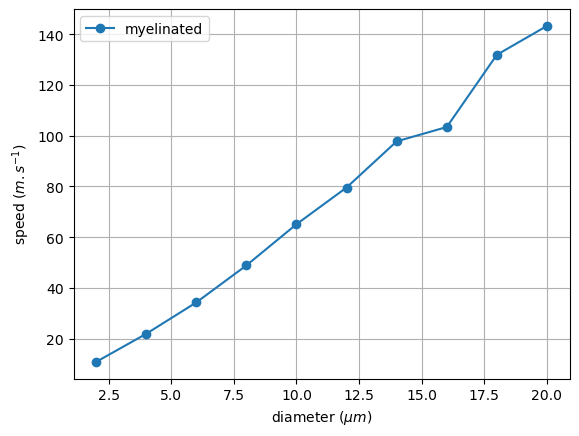

In [9]:
myelinated_diameters = np.linspace(2, 20, 10)   #10 myelinated fibers with diameter ranging from 2µm to 20µm.
myelinated_speed = []

## Axon def
y = 0
z = 0
model = "MRG"

## test pulse
t_start = 1
duration = 0.1
amplitude = 5

t_sim = 5

for d in myelinated_diameters:
    L = nrv.get_length_from_nodes(d, 21)  
    axon1 = nrv.myelinated(y, z, d, L, model=model)
    axon1.insert_I_Clamp(0, t_start, duration, amplitude)

    ## Simulation
    results = axon1(t_sim=t_sim)
    del axon1

    results.rasterize("V_mem")
    myelinated_speed += [results.get_avg_AP_speed()]

fig, ax  = plt.subplots()
ax.plot(myelinated_diameters, myelinated_speed, "o-", label="myelinated")
ax.legend()
ax.grid()
ax.set_xlabel(r"diameter ($\mu m$)")
ax.set_ylabel(r"speed ($m.s^{-1}$)")

Myelinated and unmyelinated AP velocities can be plotted in the same
figure (in log scale), clearly demonstrating the AP propagation speed
gain provided by the axon’s myelin sheath.

Text(0, 0.5, 'speed ($m.s^{-1}$)')

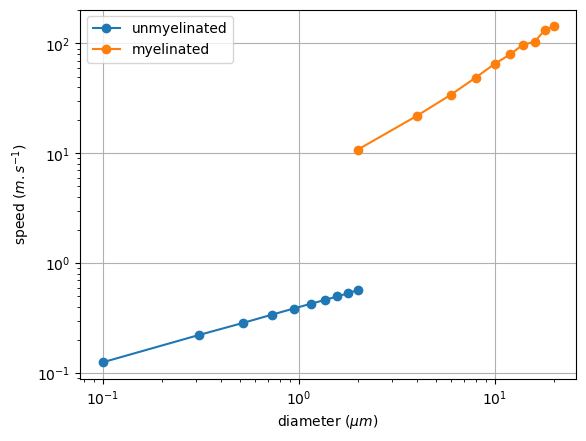

In [10]:
fig, ax  = plt.subplots()
ax.loglog(unmyelinated_diameters, unmyelinated_speed, "o-", label="unmyelinated")
ax.loglog(myelinated_diameters, myelinated_speed, "o-", label="myelinated")
ax.legend()
ax.grid()
ax.set_xlabel(r"diameter ($\mu m$)")
ax.set_ylabel(r"speed ($m.s^{-1}$)")

## Effect of model on Velocity-diameter relationship

The user can choose between several unmyelinated and myelinated
computationnal models commonly found in the literature. Available
unmyelinated model are the ``Rattay_Aberham`` model (Rattay and Aberham,
1993), the ``HH`` model (Hodgkin and Huxley, 1952), the ``Sundt`` model
(Sundt et al. 2015), the ``Tigerholm`` model (Tigerholm et al. 2014),
the ``Schild_94`` model (Schild et al. 1994) and the ``Schild_97`` model
(Schild et al. 1997). For myelinated fibers, available myelinated models
are the ``MRG`` model (McIntyre et al., 2002), the ``Gaines_sensory``
and ``Gaines_motor`` models (Gaines et al., 2018). Each computational
model has specific ion channels and membrane characteristics, resulting
in differences in propagation speed. Let’s see how this changes for
myelinated fibers. This typically takes between one to two minutes to
run.

Simulated model: MRG
Simulated model: Gaines_motor
Simulated model: Gaines_sensory


Text(0, 0.5, 'speed ($m.s^{-1}$)')

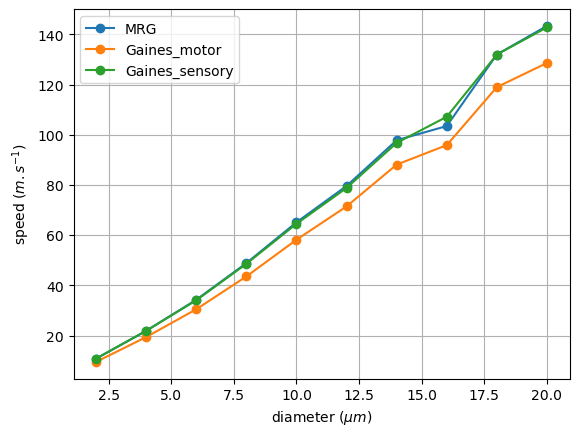

In [11]:
myelinated_diameters = np.linspace(2, 20, 10)   #10 myelinated fibers with diameter ranging from 2µm to 20µm.

## Axon def
y = 0
z = 0

## test pulse
t_start = 1
duration = 0.1
amplitude = 5

t_sim = 5

fig, ax  = plt.subplots()

myelinated_models = ['MRG','Gaines_motor','Gaines_sensory']
for model in myelinated_models:
    myelinated_speed = []
    print(f"Simulated model: {model}")
    for d in myelinated_diameters:
        L = nrv.get_length_from_nodes(d, 21)  
        axon1 = nrv.myelinated(y, z, d, L, model=model)
        axon1.insert_I_Clamp(0, t_start, duration, amplitude)
        ## Simulation
        results = axon1(t_sim=t_sim)
        del axon1
        results.rasterize("V_mem")
        myelinated_speed += [results.get_avg_AP_speed()]
    ax.plot(myelinated_diameters, myelinated_speed, "o-", label=model)

ax.legend()
ax.grid()
ax.set_xlabel(r"diameter ($\mu m$)")
ax.set_ylabel(r"speed ($m.s^{-1}$)")

Although not identical, the 3 models have very similar propagation
speeds. Indeed, these models are very similar, Gaines’ versions being
directly derived from the MRG model. Let's do the same thing but with
unmyelinated models:

Simulated model: HH
Simulated model: Rattay_Aberham
Simulated model: Sundt
Simulated model: Tigerholm


Text(0, 0.5, 'speed ($m.s^{-1}$)')

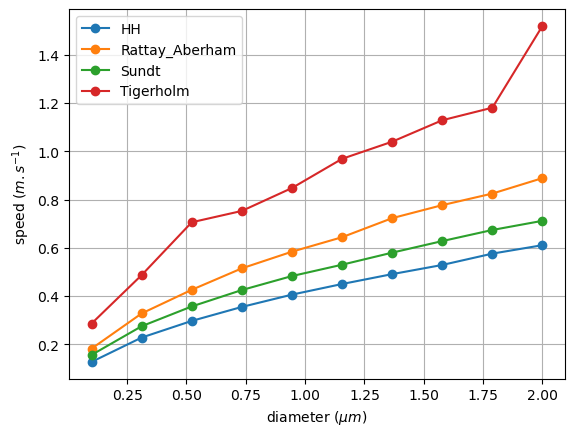

In [12]:
unyelinated_diameters = np.linspace(0.1, 2, 10)   #10 unmyelinated fibers with diameter ranging from 0.1µm to 2µm.

## Axon def
y = 0
z = 0
L = 1000

## test pulse
t_start = 1
duration = 0.1
amplitude = 5

t_sim = 10

fig, ax  = plt.subplots()
unmyelinated_models = ["HH","Rattay_Aberham","Sundt","Tigerholm"]
for model in unmyelinated_models:
    unmyelinated_speed = []
    print(f"Simulated model: {model}")
    for d in unmyelinated_diameters: 
        axon1 = nrv.unmyelinated(y, z, d, L, model=model)
        axon1.insert_I_Clamp(0, t_start, duration, amplitude)
        results = axon1(t_sim=t_sim)
        del axon1
        results.rasterize("V_mem")
        unmyelinated_speed += [results.get_avg_AP_speed()]
    ax.plot(unmyelinated_diameters, unmyelinated_speed, "o-", label=model)

ax.legend()
ax.grid()
ax.set_xlabel(r"diameter ($\mu m$)")
ax.set_ylabel(r"speed ($m.s^{-1}$)")

On the other hand, we can see that the differences in propagation speed
between the different models of unmyelinated fibers are much more
pronounced. As a matter of fact, these different models were developed
using different data and for different purposes, which is why they
differ so much. These models are described in detail in Pelot et
al. (Pelot et al. 2021).